# Are the Yu-Gi-Oh cards with the highest ATK/DEF/Level more individualist?

**Author**: Farès Blibeche

**Date**: May, 2025

## 0. Problem

In the famous Japanese card game Yu-Gi-Oh, there are thousands of ways to play by using card combinations that are more original than others. However, if there's one issue faced by all players, it's deck synergy — the ability of a 40-card deck (chosen by the player) to work as a coherent whole. This means having cards that can summon each other or interact effectively through their effects — specific powers unique to each card, described in a short piece of text. The only simple way to evaluate this synergy is by counting how many times other cards are mentioned in each card's effect text.

In this study, we aim to answer the following question:

**Are the strongest cards — in terms of attack, defence, and level — less likely to refer to other cards in their effects?**

#### Directed Acyclic Graph of our theory

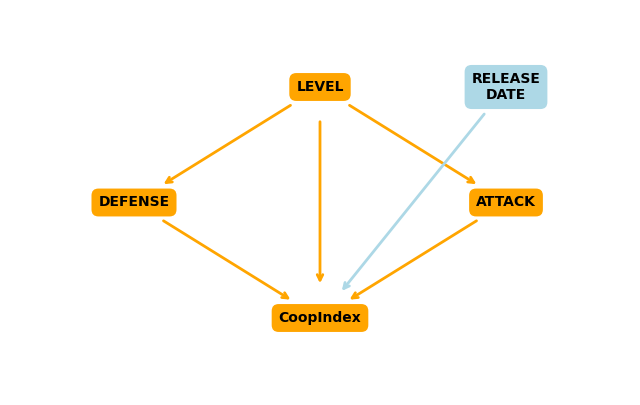

In [55]:
import matplotlib.pyplot as plt

nodes = {
    "LEVEL": (0.5, 0.8),
    "DEFENSE": (0.2, 0.5),
    "ATTACK": (0.8, 0.5),
    "RELEASE\nDATE": (0.8, 0.8),
    "CoopIndex": (0.5, 0.2)
}

edges = [
    ("LEVEL", "DEFENSE", "orange"),
    ("LEVEL", "CoopIndex", "orange"),
    ("LEVEL", "ATTACK", "orange"),
    ("DEFENSE", "CoopIndex", "orange"),
    ("ATTACK", "CoopIndex", "orange"),
    ("RELEASE\nDATE", "CoopIndex", "lightblue")
]

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off')

for start, end, color in edges:
    ax.annotate("", xy=nodes[end], xytext=nodes[start],
                arrowprops=dict(arrowstyle="->", color=color, lw=2, shrinkA=25, shrinkB=25))

for label, (x, y) in nodes.items():
    color = "lightblue" if "RELEASE" in label else "orange"
    ax.text(x, y, label, ha='center', va='center', fontweight='bold',
            bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.5'))

plt.show()

## 1. Libraries import

In [56]:
import csv
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import itertools
import re
import statsmodels.formula.api as smf

## 2. Data import

In [57]:
df = pd.read_csv("data/dataset.csv")
display(df)

,name,desc,atk,defe,attribute,type,frametype,level
0,"""A"" Cell Breeding Device","During each of your Standby Phases, put 1 A-Co...",NaN,NaN,NaN,Continuous,spell,NaN
1,"""A"" Cell Incubator",Each time an A-Counter(s) is removed from play...,NaN,NaN,NaN,Continuous,spell,NaN
2,"""A"" Cell Recombination Device",Target 1 face-up monster on the field; send 1 ...,NaN,NaN,NaN,Quick-Play,spell,NaN
3,"""A"" Cell Scatter Burst","Select 1 face-up ""Alien"" monster you control. ...",NaN,NaN,NaN,Quick-Play,spell,NaN
4,"""Case of K9""","When this card is activated: You can add 1 ""K9...",NaN,NaN,NaN,Continuous,spell,NaN
...,...,...,...,...,...,...,...,...
13611,ZW - Sleipnir Mail,"You can target 1 ""Utopia"" monster you control;...",1000.0,1000.0,LIGHT,Beast,effect,4.0
13612,ZW - Sylphid Wing,"You can only control 1 ""ZW - Sylphid Wing"". Yo...",800.0,1600.0,LIGHT,Beast,effect,4.0
13613,ZW - Tornado Bringer,"You can target 1 ""Utopia"" monster you control;...",1300.0,1800.0,WIND,Dragon,effect,5.0
13614,ZW - Ultimate Shield,When this card is Normal or Special Summoned: ...,0.0,2000.0,EARTH,Aqua,effect,4.0


## 3.1 Data manipulation in df

In [58]:
df["frametype"] = df["frametype"].replace({
    "spell": "Spell Card",
    "effect": "Effect",
    "normal": "Normal Monster",
    "link": "Link",
    "trap": "Trap Card",
    "fusion": "Fusion",
    "effect_pendulum": "Pendulum",
    "xyz": "XYZ",
    "synchro": "Synchro",
    "ritual": "Ritual",
    "skill": "Skill Card",
    "token": "Token",
    "fusion_pendulum": "Pendulum",
    "normal_pendulum": "Pendulum",
    "synchro_pendulum": "Pendulum",
    "xyz_pendulum": "Pendulum",
    "ritual_pendulum": "Pendulum"
})

df = df[df["frametype"].notna()]

display(df)

,name,desc,atk,defe,attribute,type,frametype,level
0,"""A"" Cell Breeding Device","During each of your Standby Phases, put 1 A-Co...",NaN,NaN,NaN,Continuous,Spell Card,NaN
1,"""A"" Cell Incubator",Each time an A-Counter(s) is removed from play...,NaN,NaN,NaN,Continuous,Spell Card,NaN
2,"""A"" Cell Recombination Device",Target 1 face-up monster on the field; send 1 ...,NaN,NaN,NaN,Quick-Play,Spell Card,NaN
3,"""A"" Cell Scatter Burst","Select 1 face-up ""Alien"" monster you control. ...",NaN,NaN,NaN,Quick-Play,Spell Card,NaN
4,"""Case of K9""","When this card is activated: You can add 1 ""K9...",NaN,NaN,NaN,Continuous,Spell Card,NaN
...,...,...,...,...,...,...,...,...
13611,ZW - Sleipnir Mail,"You can target 1 ""Utopia"" monster you control;...",1000.0,1000.0,LIGHT,Beast,Effect,4.0
13612,ZW - Sylphid Wing,"You can only control 1 ""ZW - Sylphid Wing"". Yo...",800.0,1600.0,LIGHT,Beast,Effect,4.0
13613,ZW - Tornado Bringer,"You can target 1 ""Utopia"" monster you control;...",1300.0,1800.0,WIND,Dragon,Effect,5.0
13614,ZW - Ultimate Shield,When this card is Normal or Special Summoned: ...,0.0,2000.0,EARTH,Aqua,Effect,4.0


## 3.2 Building a graph to manipulate data 

In [59]:
def maj_words(texte): 
    """
    Returns the words that start with a capital letter in the text.
    """
    return re.findall(r'\b[A-ZÀ-ÖØ-Ý][a-zà-öø-ý]*\b', texte)

def sequence_finder(text, seq, strongness=1):
    """
    Extracts all consecutive word sequences from a text and returns those that match elements in the provided list seq.
    """
    if strongness == 0:
        word_list = text.split()
    elif strongness == 1:
        word_list = re.findall(r"\b\w+\b", text)
    chains_of_words = set()
    for i in range(len(word_list)):
        for j in range(i + 1, len(word_list) + 1): 
            chains_of_words.add(" ".join(word_list[i:j]))

    seq_set = set(seq)

    return list(seq_set.intersection(chains_of_words))

def cardname_finder(text, cardnames):
    """
    Extracts and returns card names found between double quotes if they match entries in the provided list.
    (We know that card names are always between double quotes in Yu-Gi-Oh)
    """
    result = []

    text=text+" "
    
    if '"' in text:
        coord_of_quotations = []

        for i in range(len(text)):
            if text[i] == '"':
                coord_of_quotations.append(i)
        possible_names = [text[c[0]+1:c[1]] for c in list(itertools.combinations(coord_of_quotations, 2))]
        

        for _ in possible_names:
            if _ in cardnames:
                result.append(_)
    return list(set(result))

Let’s set up a graph to organize our data! This graph will be useful later on for more in-depth analyses of the game.

In [60]:
typelist = list(df["type"].unique())
frametypelist = list(df["frametype"].unique())
namelist = list(df['name'])
attributelist = list(df["attribute"].unique())

In [61]:
class cardGraph: 
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_card_node(self, nom):
        self.graph.add_node(nom)
        self.name = nom
        self.effect = df[df["name"] == nom]["desc"].values[0]


    def add_relationship(self, source, target, type_relation):
        self.graph.add_edge(source, target, rship=type_relation)

    def extract_calls(self, description, card_source):
        if df[df["name"] == self.name]["frametype"].values[0] not in ["Skill Card", "normal", "Normal Monster", "Token"]:

            for name in cardname_finder(self.effect, namelist):
                self.add_relationship(card_source, name, "namecall")

            for frametype in sequence_finder(self.effect, frametypelist):
                for name in list(df[df["frametype"] == frametype]['name']):
                    self.add_relationship(card_source, name, "frametypecall")

            for atype in sequence_finder(self.effect, typelist):
                for name in list(df[df["type"] == atype]['name']):
                    self.add_relationship(card_source, name, "typecall")
                    
            for attribute in sequence_finder(self.effect, attributelist):
                for name in list(df[df["attribute"] == attribute]['name']):
                    self.add_relationship(card_source, name, "attributecall")


    def load_from_dataframe(self, df):
        for _, row in df.iterrows():
            nom = row["name"]
            description = row["desc"]

            self.add_card_node(nom)
            self.extract_calls(description, nom)

    def relationship_counter_bytype(self, node):
        # Initialize dictionaries to count outgoing and incoming relationships
        outgoing_rships = {}
        incoming_rships = {}

        # For each neighbor of the given node (outgoing relationships)
        for neigh in self.graph.neighbors(node):
            rship = self.graph[node][neigh].get('rship')
            if rship:
                if rship not in outgoing_rships:
                    outgoing_rships[rship] = 0
                outgoing_rships[rship] += 1

        # For each predecessor of the given node (incoming relationships)
        for pred in self.graph.predecessors(node):
            rship = self.graph[pred][node].get('rship')
            if rship:
                if rship not in incoming_rships:
                    incoming_rships[rship] = 0
                incoming_rships[rship] += 1

        return outgoing_rships, incoming_rships

    def ajouter_calls_data(self, df):
        K = ["namecall", "typecall", "attributecall", "frametypecall"]

        liste = [[[], []], [[], []], [[], []], [[], []],]
        for c in range(len(K)):
            for node in df["name"]:
                    if node in self.graph:
                        outgoing, incoming = self.relationship_counter_bytype(node)
                        liste[c][0].append(incoming.get(K[c], 0))
                        liste[c][1].append(outgoing.get(K[c], 0))
                    else:
                        liste[c][0].append(np.nan)
                        liste[c][1].append(np.nan)
            df["in"+K[c]] = liste[c][0]
            df["out"+K[c]] = liste[c][1]
        return df
    
graphe_cards = cardGraph()
graphe_cards.load_from_dataframe(df)
graphe_cards.ajouter_calls_data(df)



# I increased the number of variables used to store incoming and outgoing edges to make it easier to carry out my own analyses of the dataset

,name,desc,atk,defe,attribute,type,frametype,level,innamecall,outnamecall,intypecall,outtypecall,inattributecall,outattributecall,inframetypecall,outframetypecall
0,"""A"" Cell Breeding Device","During each of your Standby Phases, put 1 A-Co...",NaN,NaN,NaN,Continuous,Spell Card,NaN,0,0,159,165,0,0,340,0
1,"""A"" Cell Incubator",Each time an A-Counter(s) is removed from play...,NaN,NaN,NaN,Continuous,Spell Card,NaN,0,0,159,165,0,0,340,0
2,"""A"" Cell Recombination Device",Target 1 face-up monster on the field; send 1 ...,NaN,NaN,NaN,Quick-Play,Spell Card,NaN,0,0,0,0,0,0,365,0
3,"""A"" Cell Scatter Burst","Select 1 face-up ""Alien"" monster you control. ...",NaN,NaN,NaN,Quick-Play,Spell Card,NaN,0,0,0,0,0,0,365,0
4,"""Case of K9""","When this card is activated: You can add 1 ""K9...",NaN,NaN,NaN,Continuous,Spell Card,NaN,1,1,159,0,0,0,340,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13611,ZW - Sleipnir Mail,"You can target 1 ""Utopia"" monster you control;...",1000.0,1000.0,LIGHT,Beast,Effect,4.0,1,1,494,0,435,0,1513,0
13612,ZW - Sylphid Wing,"You can only control 1 ""ZW - Sylphid Wing"". Yo...",800.0,1600.0,LIGHT,Beast,Effect,4.0,1,1,494,0,435,0,1513,0
13613,ZW - Tornado Bringer,"You can target 1 ""Utopia"" monster you control;...",1300.0,1800.0,WIND,Dragon,Effect,5.0,1,1,877,0,185,0,1412,0
13614,ZW - Ultimate Shield,When this card is Normal or Special Summoned: ...,0.0,2000.0,EARTH,Aqua,Effect,4.0,1,1,88,2280,244,0,1574,0


## 3.3 Let's clean data a second time and set up *coopIndex*

We remove cards without effects, without attack, without defense and without levels to keep only effect monsters in a broad sense.

In [62]:
def filter(df):
    excluded_frametypes = ["Skill Card", "Normal Monster", "Token", "Trap Card", "Spell Card"] 
    
    # Apply filter
    filtre = (
        (~df["frametype"].isin(excluded_frametypes)) &
        (df["atk"].notna()) &
        (df["defe"].notna()) &
        (df["level"].notna())
    )
    return df.loc[filtre].copy()

dfF = filter(df)
display(dfF)

,name,desc,atk,defe,attribute,type,frametype,level,innamecall,outnamecall,intypecall,outtypecall,inattributecall,outattributecall,inframetypecall,outframetypecall
10,3-Hump Lacooda,"If there are 3 face-up ""3-Hump Lacooda"" cards ...",500.0,1500.0,EARTH,Beast,Effect,3.0,1,1,504,0,244,0,1535,0
12,4-Starred Ladybug of Doom,FLIP: Destroy all Level 4 monsters your oppone...,800.0,1200.0,WIND,Insect,Effect,3.0,0,0,153,0,185,0,1588,0
16,8-Claws Scorpion,"Once per turn, you can flip this card into fac...",300.0,200.0,DARK,Insect,Effect,2.0,0,0,150,0,487,0,1530,0
18,A Cat of Ill Omen,FLIP: Choose 1 Trap from your Deck and place i...,500.0,300.0,DARK,Beast,Effect,2.0,0,1,501,0,487,0,1494,0
26,A Man with Wdjat,"When you Normal Summon this card, and during e...",1600.0,1600.0,DARK,Spellcaster,Effect,4.0,0,0,199,2280,487,0,1513,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13611,ZW - Sleipnir Mail,"You can target 1 ""Utopia"" monster you control;...",1000.0,1000.0,LIGHT,Beast,Effect,4.0,1,1,494,0,435,0,1513,0
13612,ZW - Sylphid Wing,"You can only control 1 ""ZW - Sylphid Wing"". Yo...",800.0,1600.0,LIGHT,Beast,Effect,4.0,1,1,494,0,435,0,1513,0
13613,ZW - Tornado Bringer,"You can target 1 ""Utopia"" monster you control;...",1300.0,1800.0,WIND,Dragon,Effect,5.0,1,1,877,0,185,0,1412,0
13614,ZW - Ultimate Shield,When this card is Normal or Special Summoned: ...,0.0,2000.0,EARTH,Aqua,Effect,4.0,1,1,88,2280,244,0,1574,0


We create a new variable named *coopIndex* that summarizes the cooperation level of each card. 
When this variable is negative, the card tends to be called by a large number of other cards; conversely, when it is positive, the card tends to call a large number of other cards.

$coopIndex_{i} = (oNamecall_{i} + oTypecall_{i} + oAttributecall_{i} + oFrametypecall_{i} - iNamecall_{i} - iTypecall_{i} - iAttributecall_{i} - iFrametypecall_{i})/8$

Next, we will normalize attack, defense, and level, since card levels range from 1 to 12, while attack and defense values can vary from 0 to approximately 5000.

In [63]:
dfF["coopIndex"] = (dfF["outnamecall"] + dfF["outtypecall"] + dfF["outattributecall"] + dfF["outframetypecall"] - dfF["innamecall"] - dfF["intypecall"] - dfF["inattributecall"] - dfF["inframetypecall"])/8

colonnes_a_garder = ["atk", "defe", "level", "coopIndex"]
dfF = dfF[colonnes_a_garder]

display(dfF)


,atk,defe,level,coopIndex
10,500.0,1500.0,3.0,-285.375
12,800.0,1200.0,3.0,-240.750
16,300.0,200.0,2.0,-270.875
18,500.0,300.0,2.0,-310.125
26,1600.0,1600.0,4.0,10.125
...,...,...,...,...
13611,1000.0,1000.0,4.0,-305.250
13612,800.0,1600.0,4.0,-305.250
13613,1300.0,1800.0,5.0,-309.250
13614,0.0,2000.0,4.0,46.750


## 4. Data description

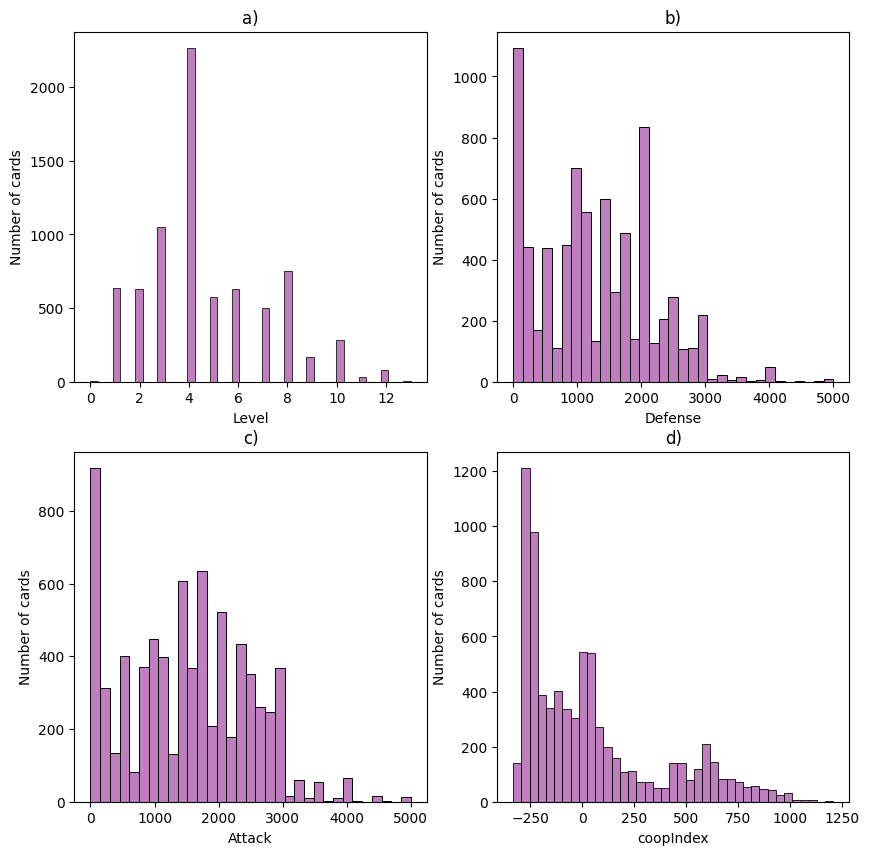

In [64]:
fig = plt.figure(figsize=(10, 10))

# Figure 1.a : Distribution of attack

plt.subplot(2, 2, 1) 
sns.histplot(dfF['level'], color= 'purple', alpha=0.5)
plt.gca().set_xlabel("Level")
plt.gca().set_ylabel("Number of cards")
plt.title("a)")

# Figure 1.b : Distribution of attack

plt.subplot(2, 2, 2) 
sns.histplot(dfF['defe'], color= 'purple', alpha=0.5)
plt.gca().set_xlabel("Defense")
plt.gca().set_ylabel("Number of cards")
plt.title("b)")

# Figure 1.c : Distribution of defense

plt.subplot(2, 2, 3) 
sns.histplot(dfF['atk'], color= 'purple', alpha=0.5)
plt.gca().set_xlabel("Attack")
plt.gca().set_ylabel("Number of cards")
plt.title("c)")

# Figure 1.d : Distribution of coopIndex

plt.subplot(2, 2, 4) 
sns.histplot(dfF['coopIndex'], color= 'purple', alpha=0.5)
plt.gca().set_xlabel("coopIndex")
plt.gca().set_ylabel("Number of cards")
plt.title("d)")

plt.show()

In [65]:
def normalize(col, data):
    data[col] = 100 * (data[col] - data[col].min())/(data[col].max() - data[col].min())

normalize("atk", dfF)
normalize("defe", dfF)
normalize("level", dfF)
normalize("coopIndex", dfF)

## 5. Data modelling

### 5.1 - Forest Plot

We computed the following multivariate linear model:

$coopIndex_{i} = \beta_{1} Atk_{i} + \beta_{2} Defe_{i} + \beta_{3} Level_{i} + \epsilon_{i}$


In [ ]:
def regression(Yname, Xlist, dataframe, printSummary):

    # Construct the regression model
    model = smf.ols(formula = Yname + ' ~ ' + " + ".join(Xlist), data = dataframe).fit()
    if printSummary == True:
        # Print the results
        print(model.summary())
    return model


model = regression('coopIndex', ['atk', 'defe', 'level'], dfF, True)

                            OLS Regression Results                            
Dep. Variable:              coopIndex   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     111.9
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           6.69e-71
Time:                        18:22:31   Log-Likelihood:                -33878.
No. Observations:                7613   AIC:                         6.776e+04
Df Residuals:                    7609   BIC:                         6.779e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.3739      0.524     29.334      0.0

### 5.2 - Forest Plot

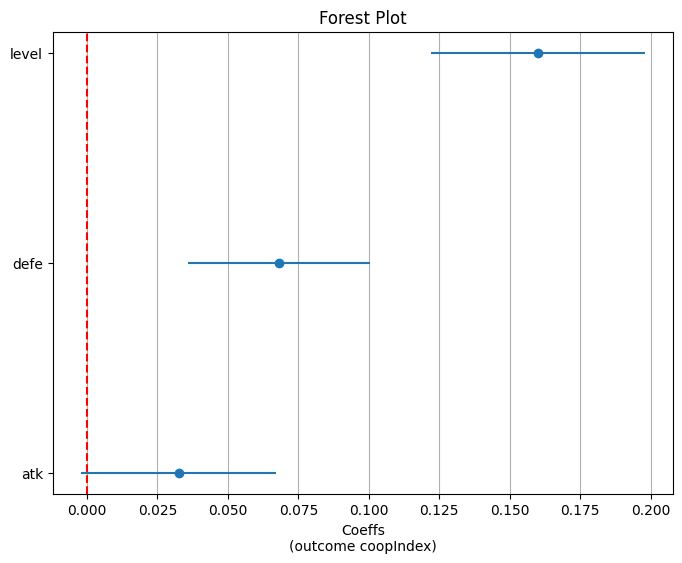

In [ ]:
# Coefficients (coef) and confidence intervals (ci)
coefs = model.params[1:4] # We select the coeficients excluding the intercept (index 0)
ci = (model.conf_int(alpha = 0.05)[1] - model.conf_int(alpha = 0.05)[0]) / 2 
ci = ci[1:5] # We select the confidence intervals excluding the intercept (index 0)
variables = ['atk', 'defe', 'level']
y_pos = range(1, len(variables)+1)

# Forest plot
plt.figure(figsize = (8, 6))
plt.errorbar(coefs, y_pos, xerr = ci, fmt = 'o', label = 'Coeffs')
plt.yticks(y_pos, variables)
plt.axvline(x = 0, linestyle = '--', color = 'red')
plt.xlabel('Coeffs\n(outcome coopIndex)')
plt.title('Forest Plot')
plt.grid(axis = 'x')
plt.show()